Nos últimos trimestres, esse aumento inesperado nas desistências causou perdas financeiras significativas, tanto pela redução do faturamento recorrente quanto pelos altos custos de aquisição de novos clientes para compensar a saída.

Preocupada com esse cenário, a diretoria da **CredMaxx** solicitou à equipe de Dados e Inteligência de Mercado um estudo completo para entender os fatores que influenciam a decisão de cancelamento e desenvolver um modelo preditivo capaz de identificar clientes com alto risco de churn.

Apesar da limitação de dados disponíveis, a empresa possui um dataset consolidado contendo informações cadastrais, de perfil e comportamento de clientes ativos e cancelados. O objetivo principal é usar essa base para:

📉 Entender padrões de cancelamento;

🧠 Explorar variáveis com maior influência no churn;

📊 Desenvolver visualizações que ajudem na tomada de decisão;

🤖 Criar um modelo de Machine Learning que antecipe a possível saída de clientes;

🎯 Auxiliar o time de CRM e Marketing a agir preventivamente, com ofertas personalizadas e estratégias de retenção.

Com insights extraídos desse projeto, a CredMaxx pretende reduzir a evasão de clientes e aumentar o tempo de vida útil de cada usuário na plataforma, otimizando seus investimentos em relacionamento e fidelização.



### Importação 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df_geral = pd.read_csv('clientes.csv', encoding='latin1')


----

### Tratamento

In [3]:
# Valores Nulos

df_geral['Categoria Cartão'] = df_geral['Categoria Cartão'].fillna('Blue')

### Perfil Inicial

#### Perfil Inicial - Funções

##### Dados Numéricos

In [4]:
# Função para retornar perfil estatístico inicial


def estatistica_descritiva_numerica(df):

    numerical = df.select_dtypes(include=('int64', 'float64', 'int32'))

    media = pd.DataFrame(numerical.mean().round()).T
    mediana = pd.DataFrame(numerical.median().round().apply(lambda x: f'{x:,.2f}')).T
    moda = pd.DataFrame(numerical.mode().iloc[0]).T
    desvio_padrao = pd.DataFrame(numerical.apply(np.std).round().apply(lambda x: f'{x:,.2f}')).T
    minimo = pd.DataFrame(numerical.min()).T
    maximo = pd.DataFrame(numerical.max().apply(lambda x: f'{x:,.2f}')).T
    quantile_1 = pd.DataFrame(numerical.quantile(0.25).apply(lambda x: f'{x:,.2f}')).T
    quantile_2 = pd.DataFrame(numerical.quantile(0.50).apply(lambda x: f'{x:,.2f}')).T
    quantile_3 = pd.DataFrame(numerical.quantile(0.75).apply(lambda x: f'{x:,.2f}')).T
    range = pd.DataFrame(numerical.apply(lambda x: x.max() - x.min()).apply(lambda x: f'{x:,.2f}')).T
    skew = pd.DataFrame(numerical.apply(lambda x: x.skew()).apply(lambda x: f'{x:,.3f}')).T
    kurtosis = pd.DataFrame(numerical.apply(lambda x: x.kurtosis()).apply(lambda x: f'{x:.3f}')).T
  
    nome_df = '_stats'
    stats_df = pd.concat([media, mediana, moda, desvio_padrao, minimo, maximo, range, quantile_1, quantile_2, quantile_3, skew, kurtosis]).T.reset_index()
    # Definir os nomes das colunas
    stats_df.columns = [nome_df, 'Média', 'Mediana', 'Moda', 'Desvio Padrão', 'Mínimo', 'Máximo', 'Range', '25%', '50%', '75%', 'Skew', 'Kurtosis']  
    return stats_df


##### Dados Categóricos

In [5]:
# Função para retornar perfil estatístico inicial
def estatistica_descritiva_categorica(df):

    character = df.select_dtypes(include=('object')) 

    # criar Dataframe
    stats = pd.DataFrame()

    # número de categorias únicas
    stats['N° de Categorias Únicas'] = character.nunique()

    #moda
    stats['Moda'] = character.mode().iloc[0]

    #frequência da moda
    stats['Frequência da Moda'] = character.apply(lambda x: x.value_counts().iloc[0])

    #proporção da moda
    stats['Proporção da Moda'] = (stats['Frequência da Moda'] / len(character)).apply(lambda x: f'{x:.2%}')

    #menor frequência
    stats['Categoria de menor frequência'] = character.apply(lambda x: x.value_counts().idxmin())

    #numero da menor frequência
    stats['Menor frequência'] = character.apply(lambda x: x.value_counts().min())

    #proporção da menor frequência
    stats['Proporção da menor frequência'] = (stats['Menor frequência'] / len(character)).apply(lambda x: f'{x:.2%}')

    return stats



##### Função de Perfil

In [6]:
#Função para retornar tabelas de ocorrência, tipo e valores nulos
def dimensao_na(df):

    unique_values = df.apply(lambda x: x.nunique())
    na_values = df.isnull().sum()

    nome_df = pd.DataFrame({
        'Quantidade de Valores' : unique_values,
        'Tipo de Coluna' : df.dtypes,
        'Quantidade de Nulos' : na_values
    }).reset_index()

    return nome_df

In [7]:
def dados_gerais(df):

    print("\n--- Valores Nulos e Dimensões ---")
    try:
        display(dimensao_na(df))
    except Exception as e:
        print(f"Erro ao calcular valores nulos ou dimensões: {e}")
    

    print("\n--- Estatísticas Categóricas ---")
    try:
        display(estatistica_descritiva_categorica(df))
    except Exception as e:
        print(f"Erro ao calcular estatísticas categóricas: {e}")

    print("\n--- Estatísticas Numéricas ---")
    try:
        display(estatistica_descritiva_numerica(df))
    except Exception as e:
        print(f"Erro ao calcular estatísticas numéricas: {e}")

----

#### Perfil Inicial - Saída

In [8]:
dados_gerais(df_geral)


--- Valores Nulos e Dimensões ---


,index,Quantidade de Valores,Tipo de Coluna,Quantidade de Nulos
0,CLIENTNUM,10127,int64,0
1,Categoria,2,object,0
2,Idade,45,int64,0
3,Sexo,2,object,0
4,Dependentes,6,int64,0
5,Educação,7,object,0
6,Estado Civil,4,object,0
7,Faixa Salarial Anual,6,object,0
8,Categoria Cartão,4,object,0
9,Meses como Cliente,44,int64,0



--- Estatísticas Categóricas ---


,N° de Categorias Únicas,Moda,Frequência da Moda,Proporção da Moda,Categoria de menor frequência,Menor frequência,Proporção da menor frequência
Categoria,2,Cliente,8500,83.93%,Cancelado,1627,16.07%
Sexo,2,F,5358,52.91%,M,4769,47.09%
Educação,7,Ensino Superior,3128,30.89%,Doutorado,451,4.45%
Estado Civil,4,Casado,4687,46.28%,Divorciado,748,7.39%
Faixa Salarial Anual,6,Less than $40K,3561,35.16%,$120K +,727,7.18%
Categoria Cartão,4,Blue,9436,93.18%,Platinum,20,0.20%



--- Estatísticas Numéricas ---


,_stats,Média,Mediana,Moda,Desvio Padrão,Mínimo,Máximo,Range,25%,50%,75%,Skew,Kurtosis
0,CLIENTNUM,739177606.0,"717,926,358.00",708082083.0,"36,901,961.00",708082083.0,"828,343,083.00","120,261,000.00","713,036,770.50","717,926,358.00","773,143,533.00",0.996,-0.616
1,Idade,46.0,46.00,44.0,8.00,26.0,73.00,47.00,41.00,46.00,52.00,-0.034,-0.289
2,Dependentes,2.0,2.00,3.0,1.00,0.0,5.00,5.00,1.00,2.00,3.00,-0.021,-0.683
3,Meses como Cliente,36.0,36.00,36.0,8.00,13.0,56.00,43.00,31.00,36.00,40.00,-0.107,0.400
4,Produtos Contratados,4.0,4.00,3.0,2.00,1.0,6.00,5.00,3.00,4.00,5.00,-0.162,-1.006
5,Inatividade 12m,2.0,2.00,3.0,1.00,0.0,6.00,6.00,2.00,2.00,3.00,0.633,1.099
6,Contatos 12m,2.0,2.00,3.0,1.00,0.0,6.00,6.00,2.00,2.00,3.00,0.011,0.001
7,Limite,8632.0,"4,549.00",34516.0,"9,088.00",1438.3,"34,516.00","33,077.70","2,555.00","4,549.00","11,067.50",1.667,1.809
8,Limite Consumido,1163.0,"1,276.00",0.0,815.00,0.0,"2,517.00","2,517.00",359.00,"1,276.00","1,784.00",-0.149,-1.146
9,Limite Disponível,7469.0,"3,474.00",1438.3,"9,090.00",3.0,"34,516.00","34,513.00","1,324.50","3,474.00","9,859.00",1.662,1.799


### EDA

A partir do contexto de negócio apresentado e a demanda fundamental de diminuir a taxa de churn na empresa, essa análise exploratória inicial tem como objetivo responder algumas perguntas e definir alguns padrões de risco entre os clientes que cancelaram o cartão, como:

- **Taxa de inatividade**
- **Uso do cartão**
- **Quedas abruptas de transações**
- **Valores Transacionados**
- **Tempo como cliente**
- **Relação entre limite disponível e limite consumido**
- **Taxa de contato com o SAC**

Para proseguir, vamos dividir a tabela entre clientes e cancelados:

In [9]:
df_cliente = df_geral[df_geral['Categoria'] == 'Cliente']
df_cancelado = df_geral[df_geral['Categoria'] == 'Cancelado']

In [10]:
#Taxa de Churn de 16% no período
churn_rate = (df_geral['Categoria'] == 'Cancelado').mean()
churn_rate

np.float64(0.1606596227905599)

In [11]:
df_geral.sample(5)

,CLIENTNUM,Categoria,Idade,Sexo,Dependentes,Educação,Estado Civil,Faixa Salarial Anual,Categoria Cartão,Meses como Cliente,Produtos Contratados,Inatividade 12m,Contatos 12m,Limite,Limite Consumido,Limite Disponível,Mudanças Transacoes_Q4_Q1,Valor Transacoes 12m,Qtde Transacoes 12m,Mudança Qtde Transações_Q4_Q1,Taxa de Utilização Cartão
9585,757256358,Cliente,45,M,3,Ensino Superior,Solteiro,$60K - $80K,Blue,38,1,3,3,3243.0,1580,1663.0,1075.000,15710,122,0.743,0.487
1702,799249833,Cliente,34,M,2,Ensino Superior,Solteiro,Less than $40K,Blue,28,5,1,4,4439.0,844,3595.0,0.863,2858,71,0.690,0.190
5007,709857033,Cliente,60,F,1,Ensino Superior Incompleto,Solteiro,$40K - $60K,Blue,50,5,1,3,1438.3,0,1438.3,0.578,4148,84,0.714,0.000
4653,721424583,Cliente,35,F,1,Ensino Médio,Casado,Less than $40K,Blue,26,4,2,3,1918.0,900,1018.0,0.873,4237,76,0.900,0.469
9848,773172483,Cancelado,30,M,0,Ensino Superior,Casado,$40K - $60K,Blue,23,6,2,4,4063.0,0,4063.0,0.776,7463,70,0.707,0.000


#### Taxa de Inatividade

Segundo os gráficos extraídos sobre as taxas de inatividade do uso do cartão em relação aos clientes e cancelados não parece ser muito expressiva na determinação do churn.

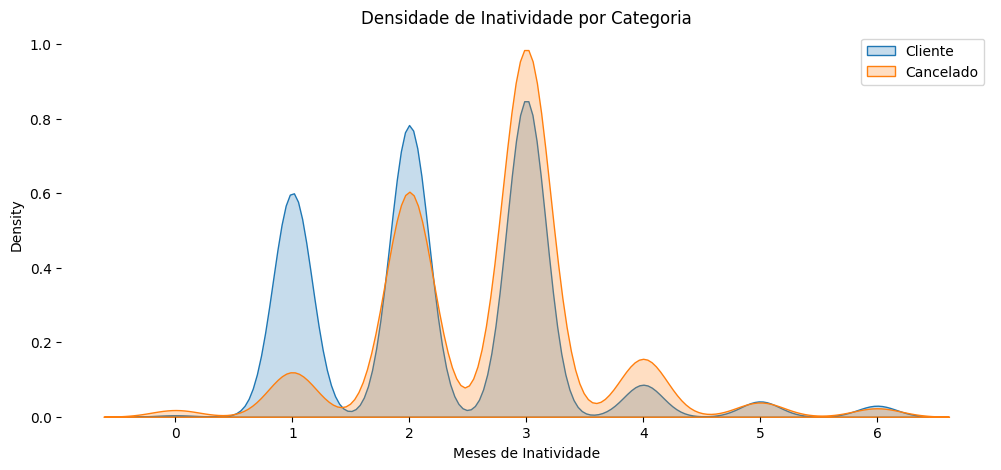

In [12]:
# Histograma 
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_cliente, x='Inatividade 12m', label='Cliente', shade=True)
sns.kdeplot(data=df_cancelado, x='Inatividade 12m', label='Cancelado', shade=True)
plt.title('Densidade de Inatividade por Categoria')
plt.legend()
plt.xlabel('Meses de Inatividade')
plt.box(None)
plt.show()


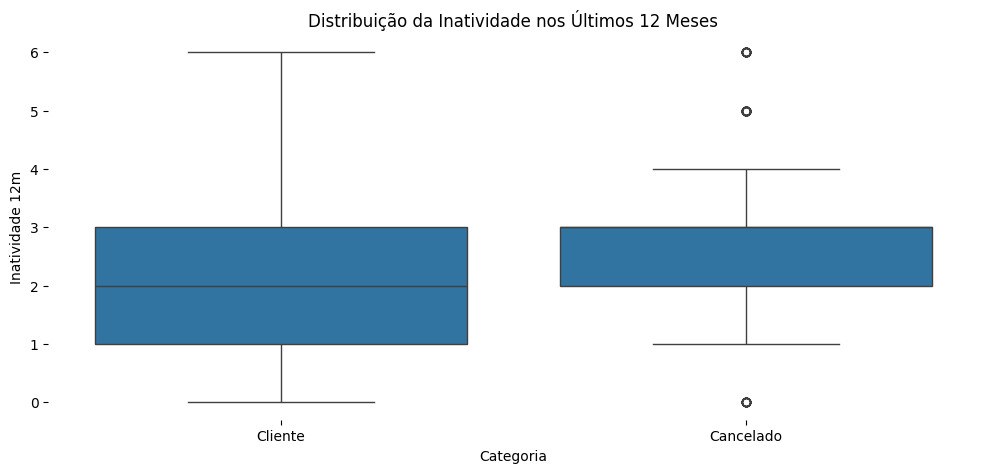

In [13]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_geral, x='Categoria', y='Inatividade 12m')
plt.title('Distribuição da Inatividade nos Últimos 12 Meses')
plt.box(None)
plt.show()

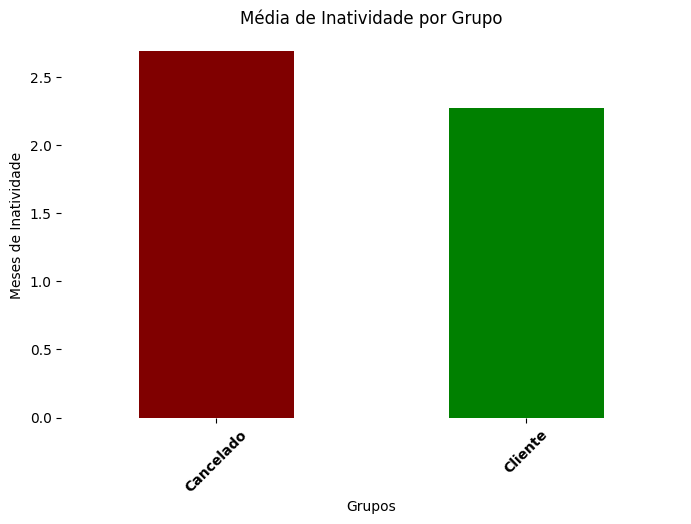

In [14]:
plt.figure(figsize=(8,5))
df_geral.groupby('Categoria')['Inatividade 12m'].mean().plot(kind='bar', color=['maroon', 'g'])
plt.title('Média de Inatividade por Grupo')
plt.ylabel('Meses de Inatividade')
plt.xlabel('Grupos')
plt.box(None)
plt.xticks(rotation=45, fontweight='semibold')
plt.show()


#### Taxa de Utilização do Cartão

A taxa de Utilização do cartão possui uma diferença entre os clientes e cancelados mais expressiva:

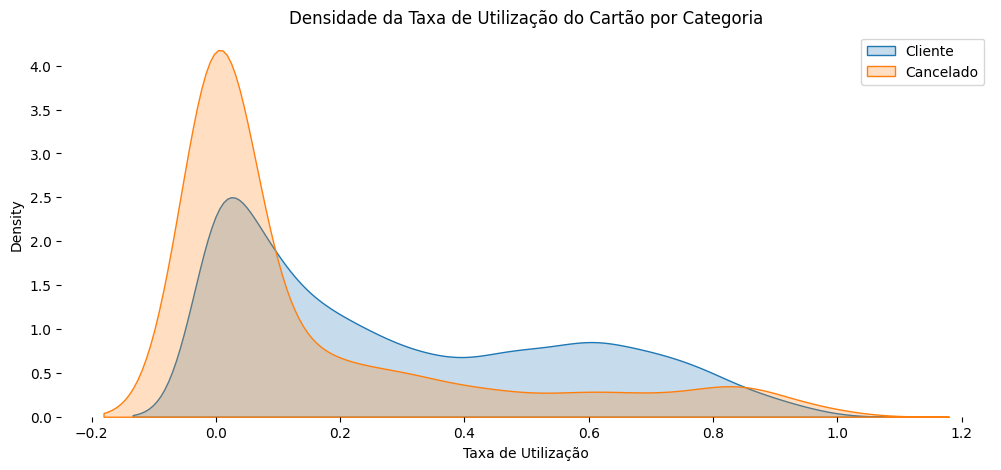

In [15]:
# Histograma 
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_cliente, x='Taxa de Utilização Cartão', label='Cliente', shade=True)
sns.kdeplot(data=df_cancelado, x='Taxa de Utilização Cartão', label='Cancelado', shade=True)
plt.title('Densidade da Taxa de Utilização do Cartão por Categoria')
plt.legend()
plt.xlabel('Taxa de Utilização')
plt.box(None)
plt.show()


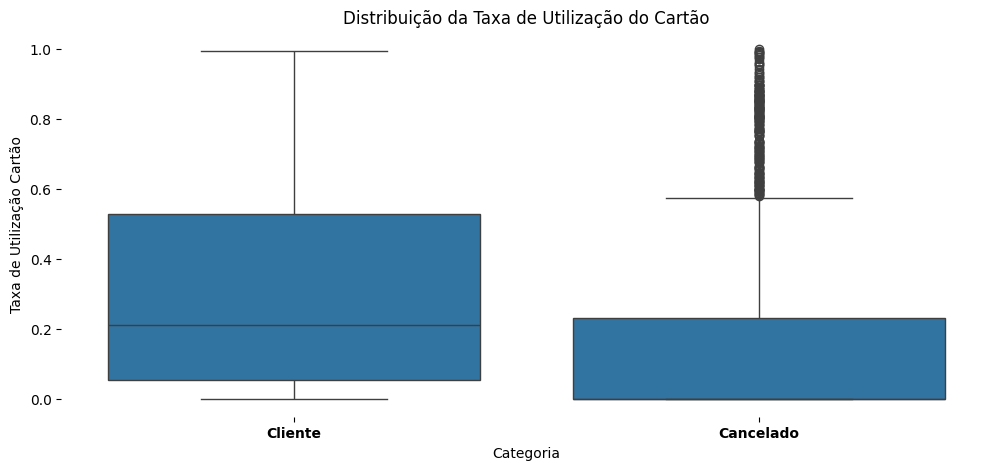

In [16]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_geral, x='Categoria', y='Taxa de Utilização Cartão')
plt.title('Distribuição da Taxa de Utilização do Cartão')
plt.xticks(fontweight='semibold')
plt.box(None)
plt.show()

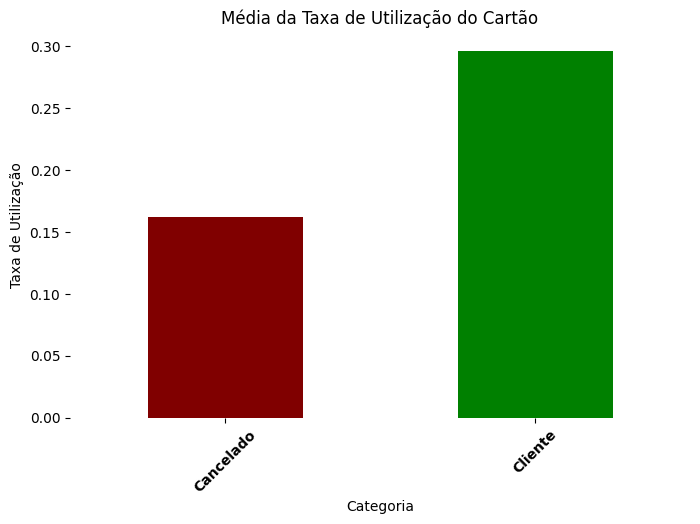

In [17]:
plt.figure(figsize=(8,5))
df_geral.groupby('Categoria')['Taxa de Utilização Cartão'].mean().plot(kind='bar', color=['maroon', 'g'])
plt.title('Média da Taxa de Utilização do Cartão')
plt.ylabel('Taxa de Utilização')
plt.xlabel('Categoria')
plt.box(None)
plt.xticks(rotation=45, fontweight='semibold')
plt.show()

#### Quantidade de Transações 12 meses

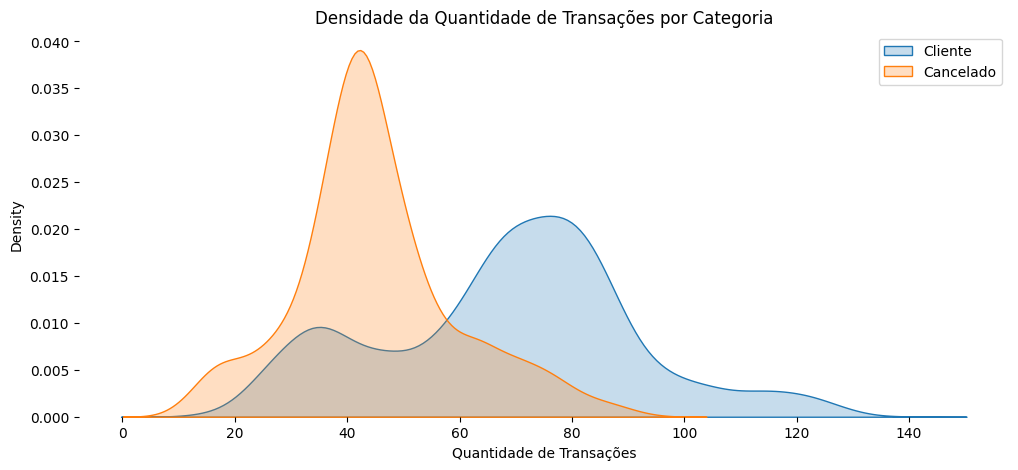

In [18]:
# Histograma 
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_cliente, x='Qtde Transacoes 12m', label='Cliente', shade=True)
sns.kdeplot(data=df_cancelado, x='Qtde Transacoes 12m', label='Cancelado', shade=True)
plt.title('Densidade da Quantidade de Transações por Categoria')
plt.legend()
plt.xlabel('Quantidade de Transações')
plt.box(None)
plt.show()


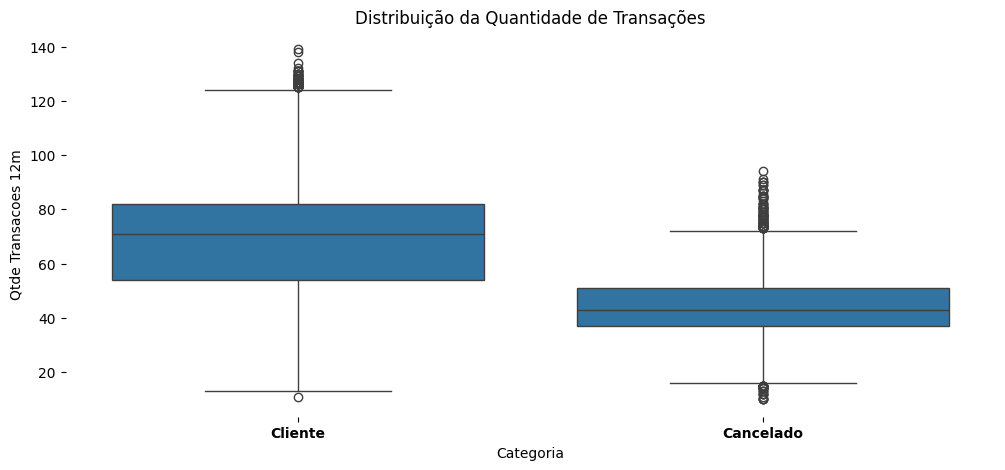

In [19]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_geral, x='Categoria', y='Qtde Transacoes 12m')
plt.title('Distribuição da Quantidade de Transações')
plt.xticks(fontweight='semibold')
plt.box(None)
plt.show()

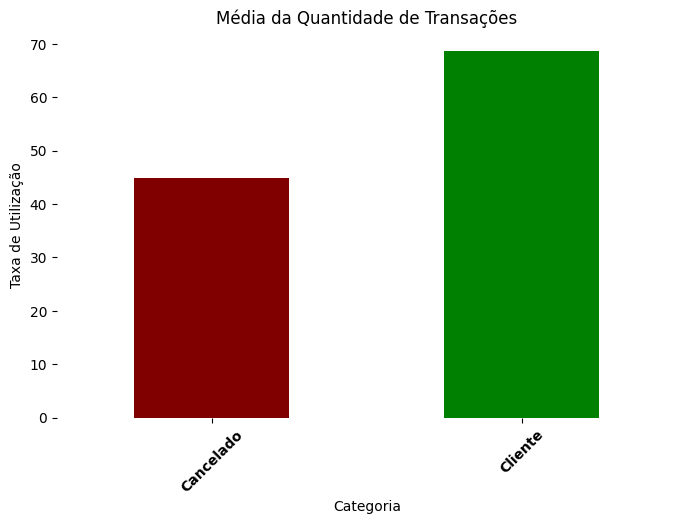

In [20]:
plt.figure(figsize=(8,5))
df_geral.groupby('Categoria')['Qtde Transacoes 12m'].mean().plot(kind='bar', color=['maroon', 'g'])
plt.title('Média da Quantidade de Transações')
plt.ylabel('Taxa de Utilização')
plt.xlabel('Categoria')
plt.box(None)
plt.xticks(rotation=45, fontweight='semibold')
plt.show()

#### Valores Transacionados

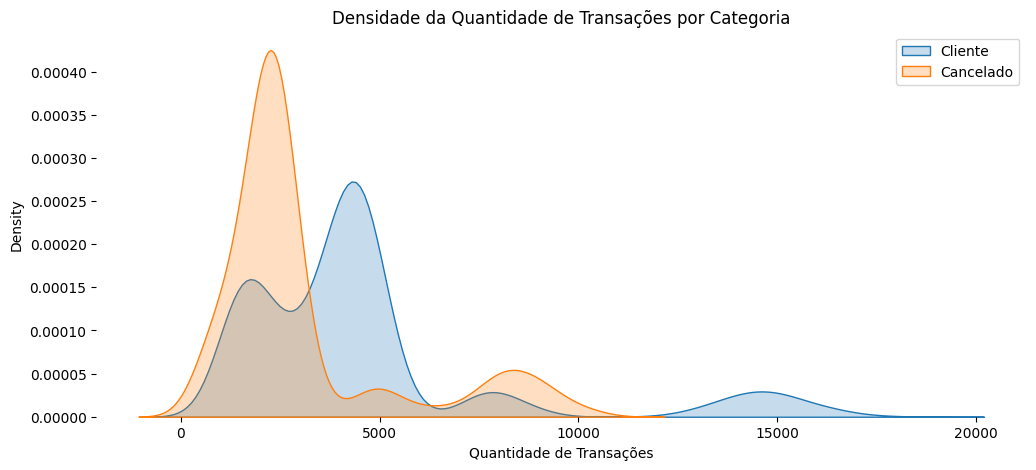

In [21]:
# Histograma 
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_cliente, x='Valor Transacoes 12m', label='Cliente', shade=True)
sns.kdeplot(data=df_cancelado, x='Valor Transacoes 12m', label='Cancelado', shade=True)
plt.title('Densidade da Quantidade de Transações por Categoria')
plt.legend()
plt.xlabel('Quantidade de Transações')
plt.box(None)
plt.show()

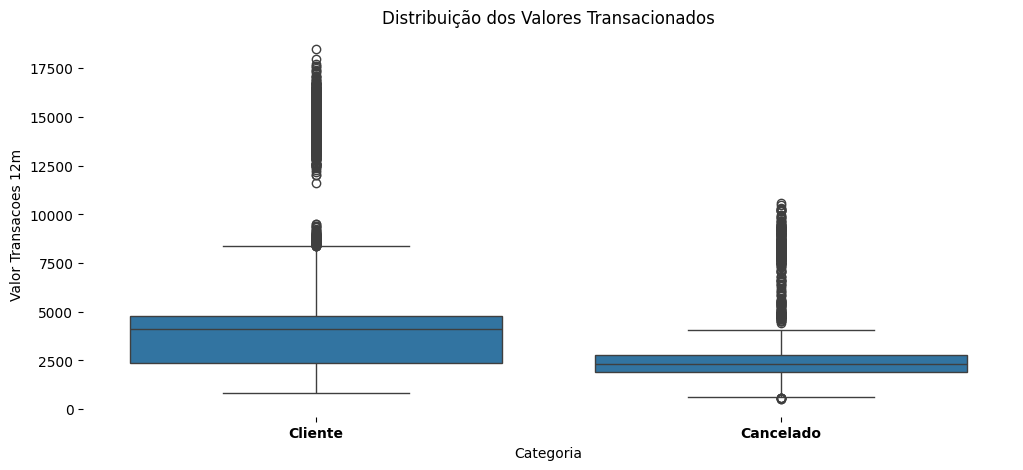

In [22]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_geral, x='Categoria', y='Valor Transacoes 12m')
plt.title('Distribuição dos Valores Transacionados')
plt.xticks(fontweight='semibold')
plt.box(None)
plt.show()

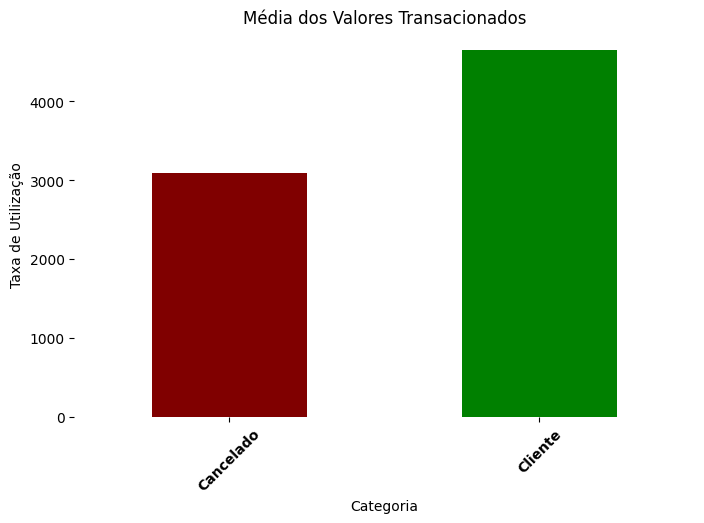

In [23]:
plt.figure(figsize=(8,5))
df_geral.groupby('Categoria')['Valor Transacoes 12m'].mean().plot(kind='bar', color=['maroon', 'g'])
plt.title('Média dos Valores Transacionados')
plt.ylabel('Taxa de Utilização')
plt.xlabel('Categoria')
plt.box(None)
plt.xticks(rotation=45, fontweight='semibold')
plt.show()

#### Tempo como Cliente

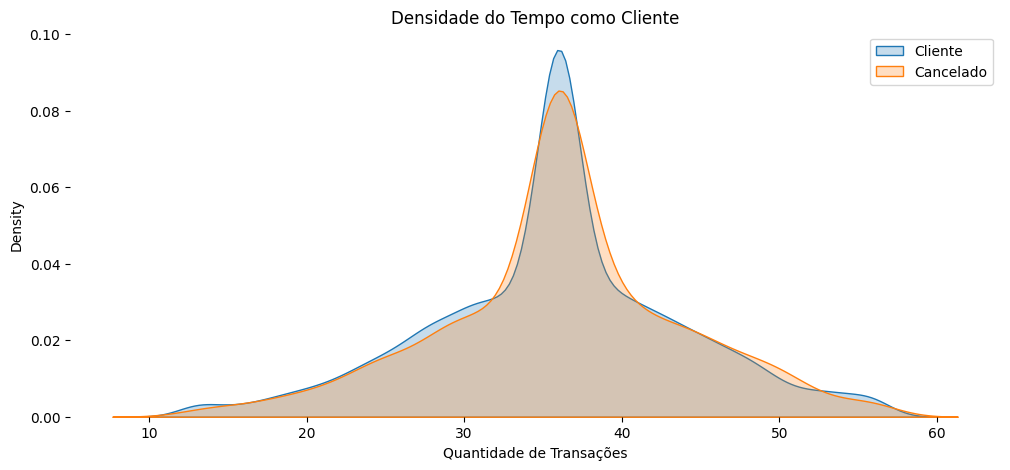

In [24]:
# Histograma 
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_cliente, x='Meses como Cliente', label='Cliente', shade=True)
sns.kdeplot(data=df_cancelado, x='Meses como Cliente', label='Cancelado', shade=True)
plt.title('Densidade do Tempo como Cliente')
plt.legend()
plt.xlabel('Quantidade de Transações')
plt.box(None)
plt.show()

#### Relação entre Limite Consumido/Disponível

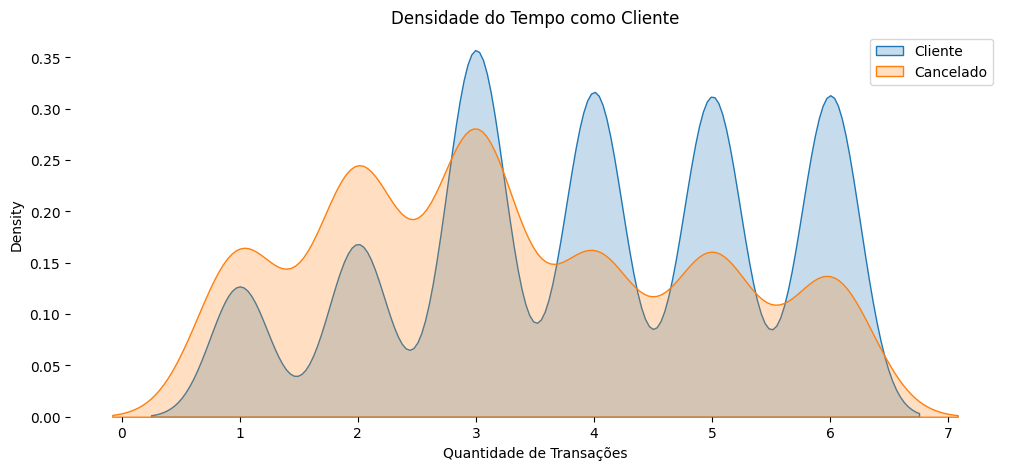

In [25]:
# Histograma 
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_cliente, x='Produtos Contratados', label='Cliente', shade=True)
sns.kdeplot(data=df_cancelado, x='Produtos Contratados', label='Cancelado', shade=True)
plt.title('Densidade do Tempo como Cliente')
plt.legend()
plt.xlabel('Quantidade de Transações')
plt.box(None)
plt.show()

#### Testes de Significância

In [ ]:
# Copia o df original
df_discretizado = df_geral.copy()

# Lista de colunas numéricas que você quer discretizar
colunas_numericas = df_geral.select_dtypes(include=['int64', 'float64']).columns.tolist()
colunas_numericas = [col for col in colunas_numericas if col != 'Categoria']  # exclui a variável alvo

# Discretização com KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

for col in colunas_numericas:
    df_discretizado[col] = kbd.fit_transform(df_geral[[col]])

# Agora aplica o teste qui-quadrado com as colunas discretizadas
variaveis_para_testar = [col for col in df_discretizado.columns if col != 'Categoria']

for var in variaveis_para_testar:
    tabela_contingencia = pd.crosstab(df_discretizado[var], df_discretizado['Categoria'])
    chi2, p, dof, expected = chi2_contingency(tabela_contingencia)
    print(f"Variável: {var}")
    print("Valor-p:", p)
    print("———" * 10)


Variável: CLIENTNUM
Valor-p: 6.749157915388929e-08
——————————————————————————————
Variável: Idade
Valor-p: 0.026836263105258225
——————————————————————————————
Variável: Sexo
Valor-p: 0.00019635846717310307
——————————————————————————————
Variável: Dependentes
Valor-p: 0.06484405242813496
——————————————————————————————
Variável: Educação
Valor-p: 0.05148913147336628
——————————————————————————————
Variável: Estado Civil
Valor-p: 0.10891263394840227
——————————————————————————————
Variável: Faixa Salarial Anual
Valor-p: 0.025002425704390617
——————————————————————————————
Variável: Categoria Cartão
Valor-p: 0.5252382797994759
——————————————————————————————
Variável: Meses como Cliente
Valor-p: 0.05906376659744895
——————————————————————————————
Variável: Produtos Contratados
Valor-p: 6.442968939729449e-60
——————————————————————————————
Variável: Inatividade 12m
Valor-p: 9.456491824735597e-80
——————————————————————————————
Variável: Contatos 12m
Valor-p: 5.25014229332562e-68
——————————————————

<Axes: >

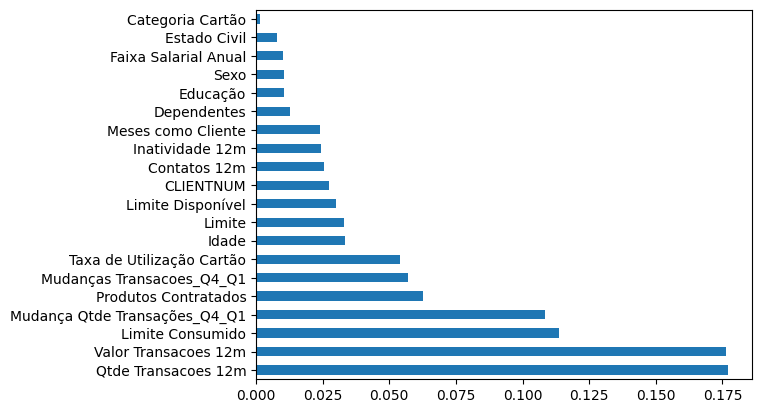

In [ ]:
# Codifique variáveis categóricas
df_encoded = df_geral.copy()
for col in df_encoded.select_dtypes(include='object'):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Separar variáveis e alvo
X = df_encoded.drop('Categoria', axis=1)
y = df_encoded['Categoria']

# Treinar modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Importância das variáveis
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh')


In [36]:
df_encoded

,CLIENTNUM,Categoria,Idade,Sexo,Dependentes,Educação,Estado Civil,Faixa Salarial Anual,Categoria Cartão,Meses como Cliente,Produtos Contratados,Inatividade 12m,Contatos 12m,Limite,Limite Consumido,Limite Disponível,Mudanças Transacoes_Q4_Q1,Valor Transacoes 12m,Qtde Transacoes 12m,Mudança Qtde Transações_Q4_Q1,Taxa de Utilização Cartão
0,768805383,1,45,1,3,1,0,2,0,39,5,1,3,12691.0,777,11914.0,1335.000,1144,42,1625.000,0.061
1,818770008,1,49,0,5,2,3,4,0,44,6,1,2,8256.0,864,7392.0,1541.000,1291,33,3714.000,0.105
2,713982108,1,51,1,3,2,0,3,0,36,4,1,0,3418.0,0,3418.0,2594.000,1887,20,2333.000,0.000
3,769911858,1,40,0,4,1,2,4,0,34,3,4,1,3313.0,2517,796.0,1405.000,1171,20,2333.000,0.760
4,709106358,1,40,1,3,6,0,2,0,21,5,1,0,4716.0,0,4716.0,2175.000,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,1,50,1,2,2,3,1,0,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,0,41,1,2,4,1,1,0,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,0,44,0,1,1,0,4,0,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,0,30,1,2,2,2,1,0,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
